In [13]:
%matplotlib inline
import pandas as pd
import simplejson as json  # faster json parsing
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [21]:
with open('yelp_academic_dataset_user.json') as f:
    user_data = pd.DataFrame(json.loads(line) for line in f)

with open('yelp_academic_dataset_review.json') as f:
    review_data = pd.DataFrame(json.loads(line) for line in f)

with open('yelp_academic_dataset_business.json') as f:
    business_data = pd.DataFrame(json.loads(line) for line in f)
    

For this data analysis experiment, we are going to first ask two questions:

 1. What is the distribution of stars produced by yelp for a business?
 2. What is the distribution of stars that a business based on the raw review data?

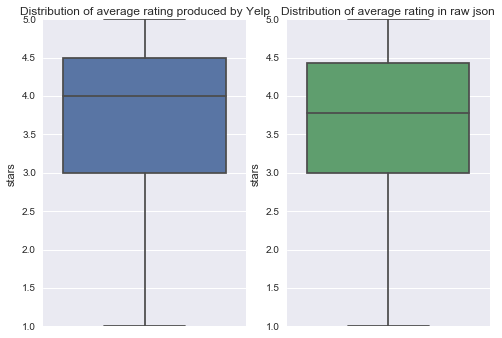

In [60]:
# use split-apply-combine to find average score by business_id
avg_scores = review_data[['business_id', 'stars']].groupby('business_id').aggregate(np.mean)

# produce a paired boxplot
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)
yelp_plot = sns.boxplot(business_data.stars, orient='v', ax=ax1, color=sns.color_palette()[0])
ax1.set_title('Distribution of average rating produced by Yelp')
review_plot = sns.boxplot(avg_scores.stars, orient='v', ax=ax2, color=sns.color_palette()[1])
ax2.set_title('Distribution of average rating in raw json')

To my eye, a few things jump out at me when comparing these graphs.
 1. The yelp curated results are skewed higher than the raw results.
 2. The yelp curated results appear to have been forced to have a upper quartile of >4.5, a mean of 4, and a lower quartile of <3.
 3. The adjustment is very small, but could be substansial in a ranked list.
 4. The yelp data are discrete and exist in the set {0, 0.25, 0.5, ..., 5}. The averages, while being drawn from that same set, can exist in a large range of values depending on the total number of reviews.
 
This leaves me with two questions:
 1. How does the average rating of a business change after adjustment? (What is the delta per business?)
 2. What do these look like as a histogram/barplot?

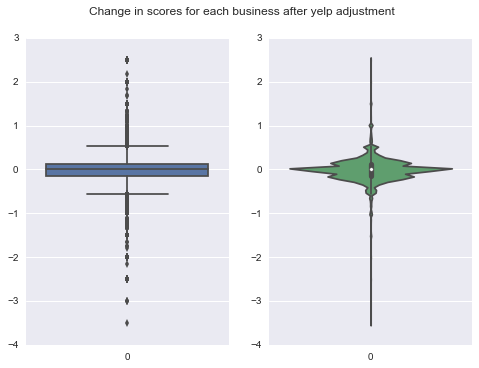

In [123]:
# calculate the change in average rating
combined = pd.merge(avg_scores.reset_index(), business_data[['business_id', 'stars']], 
                    on='business_id', suffixes=['user', 'yelp'])
delta = combined.starsuser - combined.starsyelp

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)
d_boxplot = sns.boxplot(data=delta, ax=ax1, color=sns.color_palette()[0])
d_violinplot = sns.violinplot(data=delta, ax=ax2, color=sns.color_palette()[1])
fig.suptitle('Change in scores for each business after yelp adjustment')

This plot says to me that the majority of shifts are tiny, as we would expect. However, there are some very large outliers - are these due to incomplete data, or are they doing what we want to do?

By incomplete data, I am referring to the likely fact that we are not working with the complete review set for each of these businesses, but rather a subset. I have a hunch that if we looked at some of these more extreme outliers, that they will have very few reviews in the dataset we have.

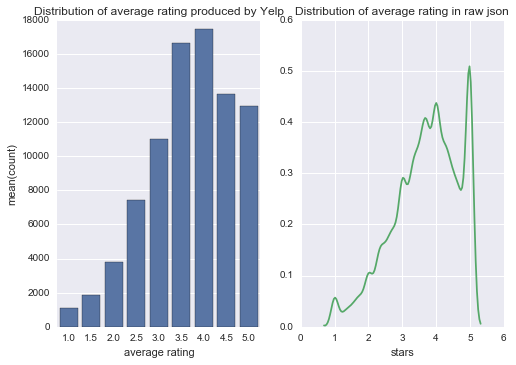

In [174]:
# extract counts data - using histograms on discrete data is a bad idea!
counts = pd.DataFrame(business_data.stars.value_counts()).reset_index()
counts.columns = ['average rating', 'count']

# produce plots. yelp data is discrete, but average reviews are continuous.
fig, (ax1, ax2) = plt.subplots(ncols=2)
yelp_plot = sns.barplot(data=counts, y='count', x='average rating', ax=ax1, color=sns.color_palette()[0])
ax1.set_title('Distribution of average rating produced by Yelp')
review_plot = sns.distplot(avg_scores.stars, ax=ax2, color=sns.color_palette()[1], hist=False)
ax2.set_title('Distribution of average rating in raw json')

We can see the underlying discrete data in the average raw results manifest as peaks at each half integer. This is probably due to low total # of reviews for those businesses. We also see a strong trend towards five stars not present in the smoothed data. 